In [1]:
# Import Necessary Libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import models,layers

In [2]:
# Handle Logs
import logging,os
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = '1'

In [3]:
# Declare useful constants
batch = 32
img_size = (256,256)
input_shape = (32,256,256,3)

In [4]:
# read image data from local disk
tf_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'apple_data',
    shuffle=True,
    image_size=img_size,
    batch_size=batch)

Found 3171 files belonging to 4 classes.


In [5]:
# Figure out information related to categories of data
classes = tf_dataset.class_names
n_classes = len(classes)
print(classes)

['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy']


(32, 256, 256, 3)


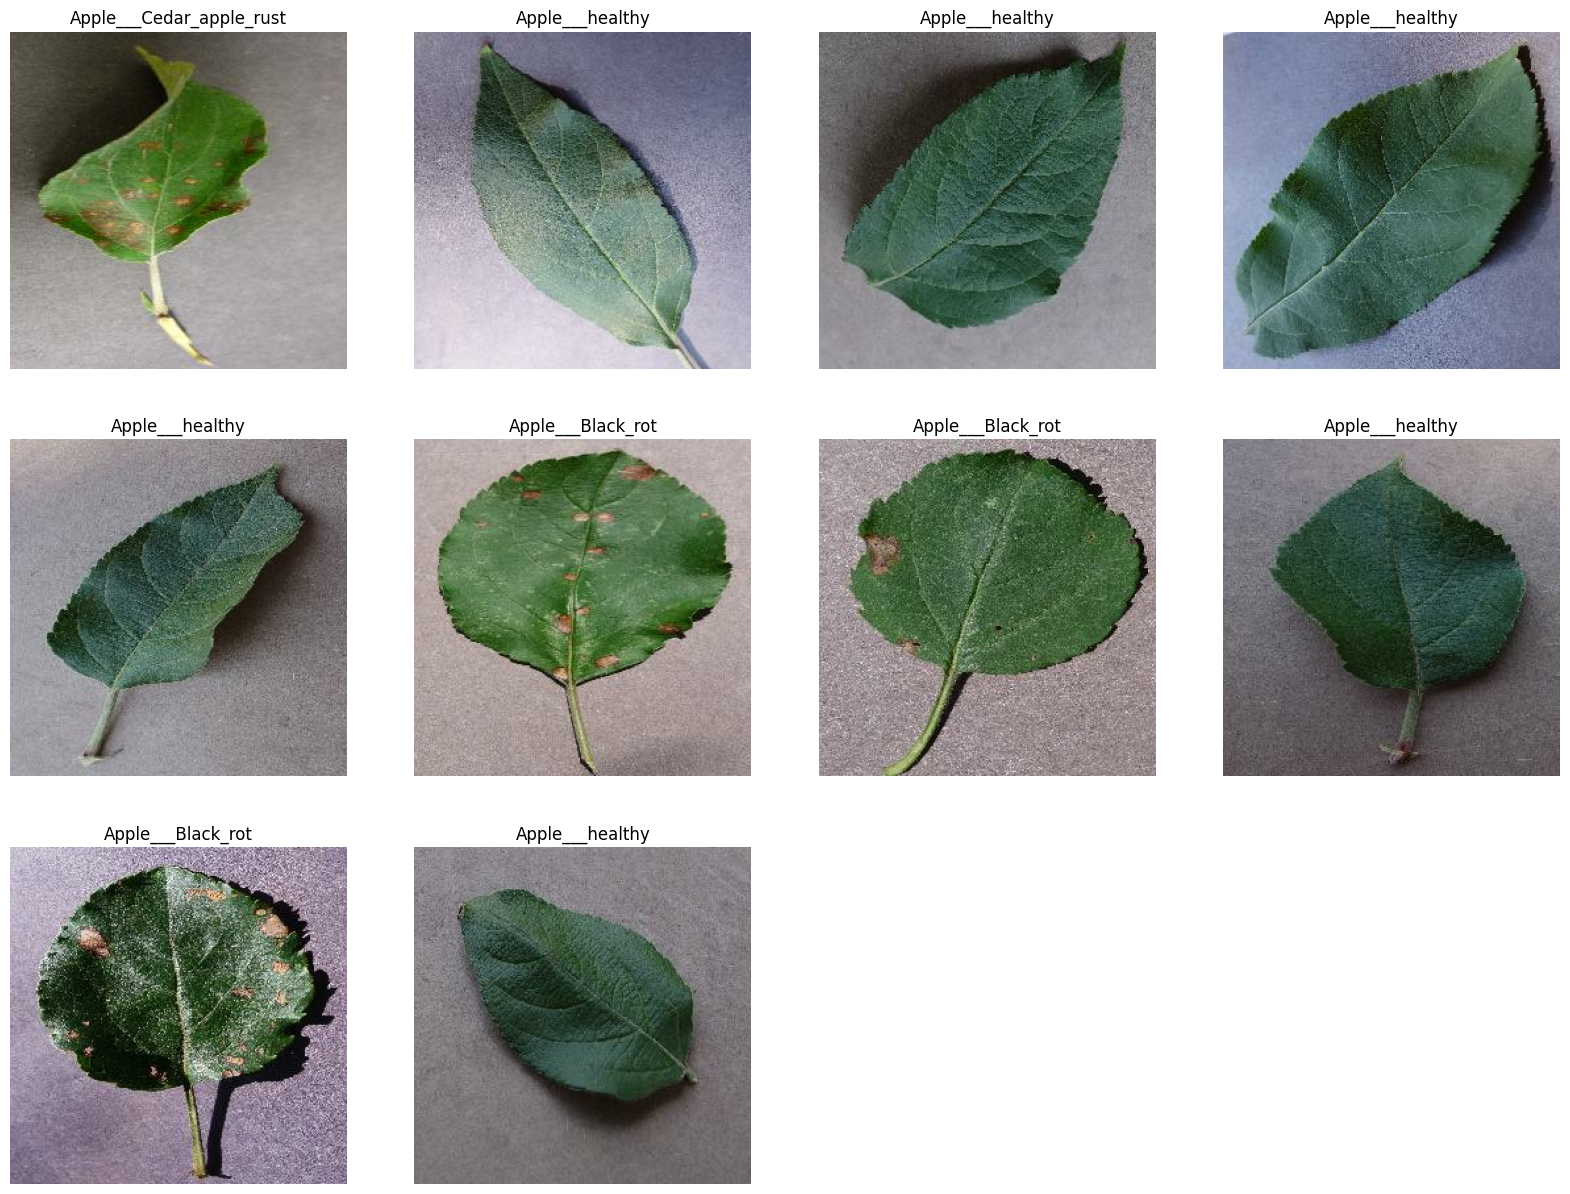

In [6]:
# Plot the images
plt.figure(figsize=(20,15))
for img_batch,label_batch in tf_dataset.take(1):
    print(img_batch.shape)
    for i in range(10):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(img_batch[i].numpy().astype('uint8'))
        plt.title(classes[label_batch[i]])
        plt.axis('off')

In [7]:
# Split the data
def split_data(data, train=0.8 , val=0.1 , test=0.1 , shuffle=True , shuffle_size=1000 ):
    total_data = len(data)
    print(total_data)
    train_size = int(train*total_data)
    val_size = int(val*total_data)
    if shuffle:
        data = data.shuffle(shuffle_size,seed=1)
    train_data = data.take(train_size)
    validation_data = data.skip(train_size).take(val_size)
    test_data = data.skip(train_size).skip(val_size)
    return train_data,validation_data,test_data

In [8]:
train_data,validation_data,test_data = split_data(tf_dataset)
print('train size: ',len(train_data))
print('val size: ',len(validation_data))
print('test size: ',len(test_data))

100
train size:  80
val size:  10
test size:  10


In [9]:
# Caching the data for improved performance
train_data = train_data.cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)
validation_data = validation_data.cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)
test_data = test_data.cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)

In [10]:
# resize and reshape the images
resize_n_shape = tf.keras.Sequential([layers.experimental.preprocessing.Resizing(256,256),
                                     layers.experimental.preprocessing.Rescaling(1.0/255)])

In [11]:
# Data Augmentation
data_augment = tf.keras.Sequential([ layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
                                    layers.experimental.preprocessing.RandomRotation(0.4)])

In [12]:
# Create Model
model = models.Sequential([
                          resize_n_shape,
                          data_augment,
                          layers.Conv2D(32,(3,3),activation='relu',input_shape = input_shape),
                          layers.MaxPool2D(pool_size=(2,2)),
                          layers.Conv2D(32,(3,3),activation='relu'),
                          layers.MaxPool2D(pool_size=(2,2)),
                          layers.Conv2D(64,(3,3),activation='relu'),
                          layers.MaxPool2D(pool_size=(2,2)),
                          layers.Conv2D(64,(3,3),activation='relu'),
                          layers.MaxPool2D(pool_size=(2,2)),
                          layers.Conv2D(128,(3,3),activation='relu'),
                          layers.MaxPool2D(pool_size=(2,2)),
                          layers.Conv2D(128,(3,3),activation='relu'),
                          layers.MaxPool2D(pool_size=(2,2)),
                          layers.Flatten(),
                          layers.Dense(128,activation='relu'),
                          layers.Dense(n_classes,activation='softmax')
])

model.build(input_shape)

In [13]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                  

In [14]:
model.compile(
optimizer='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [15]:
history = model.fit(
    train_data,
    validation_data=validation_data,
    epochs=40,
    verbose=1,
    batch_size=batch)

Epoch 1/40
80/80 [==============================] - 27s 282ms/step - loss: 1.1961 - accuracy: 0.5200 - val_loss: 1.0389 - val_accuracy: 0.5281
Epoch 2/40
80/80 [==============================] - 21s 264ms/step - loss: 0.9142 - accuracy: 0.6243 - val_loss: 0.8914 - val_accuracy: 0.5563
Epoch 3/40
80/80 [==============================] - 21s 259ms/step - loss: 0.8001 - accuracy: 0.6788 - val_loss: 0.9758 - val_accuracy: 0.5500
Epoch 4/40
80/80 [==============================] - 21s 257ms/step - loss: 0.7345 - accuracy: 0.7056 - val_loss: 0.7941 - val_accuracy: 0.6406
Epoch 5/40
80/80 [==============================] - 21s 257ms/step - loss: 0.6228 - accuracy: 0.7558 - val_loss: 0.8915 - val_accuracy: 0.6562
Epoch 6/40
80/80 [==============================] - 21s 259ms/step - loss: 0.5809 - accuracy: 0.7839 - val_loss: 0.6763 - val_accuracy: 0.7063
Epoch 7/40
80/80 [==============================] - 21s 257ms/step - loss: 0.3898 - accuracy: 0.8459 - val_loss: 0.9999 - val_accuracy: 0.7063

In [16]:
# Model Evaluation
score = model.evaluate(test_data)

10/10 [==============================] - 2s 20ms/step - loss: 0.1071 - accuracy: 0.9656


In [17]:
# Training Metrics
acc = history.history['accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']

Text(0.5, 1.0, 'Validation Progress')

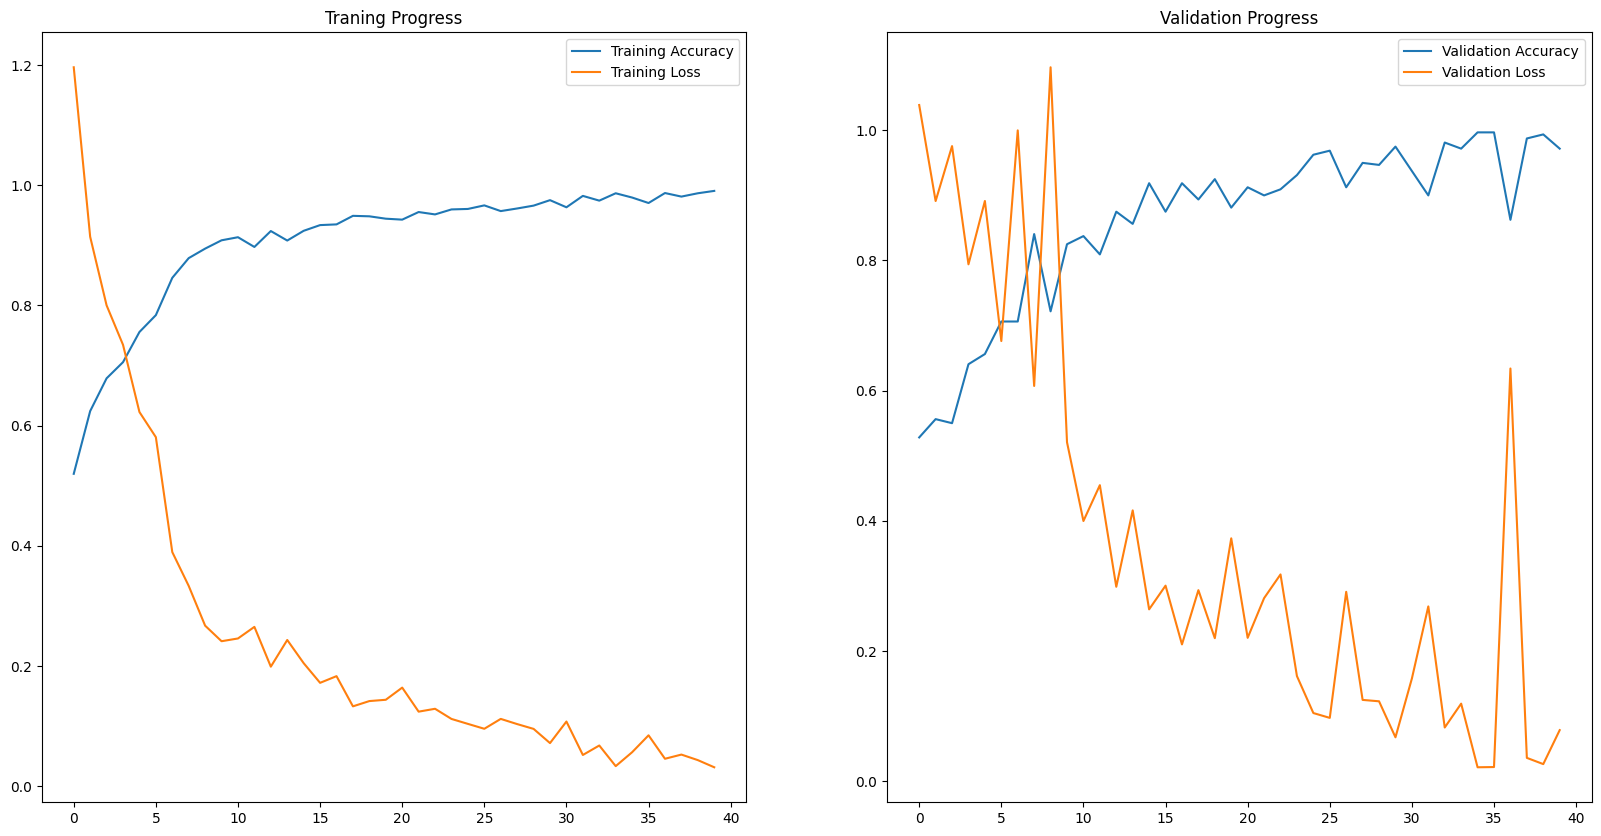

In [18]:
# Plot training graph
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.plot(acc,label='Training Accuracy')
plt.plot(loss,label='Training Loss')
plt.legend(loc = 'best')
plt.title('Traning Progress')


plt.subplot(1,2,2)
plt.plot(val_acc,label='Validation Accuracy')
plt.plot(val_loss,label='Validation Loss')
plt.legend(loc = 'best')
plt.title('Validation Progress')

actual_label: Apple___Apple_scab
predicted label: Apple___Apple_scab


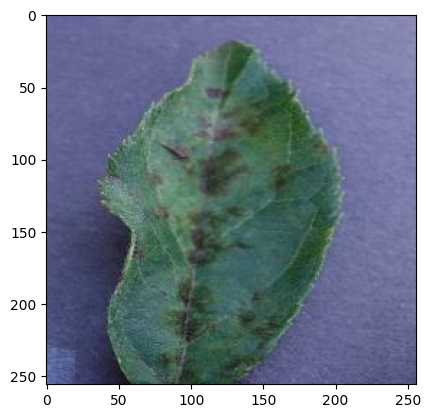

In [19]:
for img_batch,label_batch in test_data.take(1):
    img = img_batch[0].numpy().astype('uint8')
    print(f'actual_label: {classes[label_batch[0]]}')
    pred = model.predict(img_batch,verbose=0)
    print(f'predicted label: {classes[np.argmax(pred[0])]}')
    plt.imshow(img)

In [20]:
def prediction(model,image):
    img_arr = tf.keras.preprocessing.image.img_to_array(image.numpy())
    img_arr = tf.expand_dims(img_arr,0)
    
    predictions = model.predict(img_arr,verbose=0)
    pred_class = classes[np.argmax(predictions[0])]
    confidence = round(100*np.max(predictions[0]),2)
    return pred_class,confidence

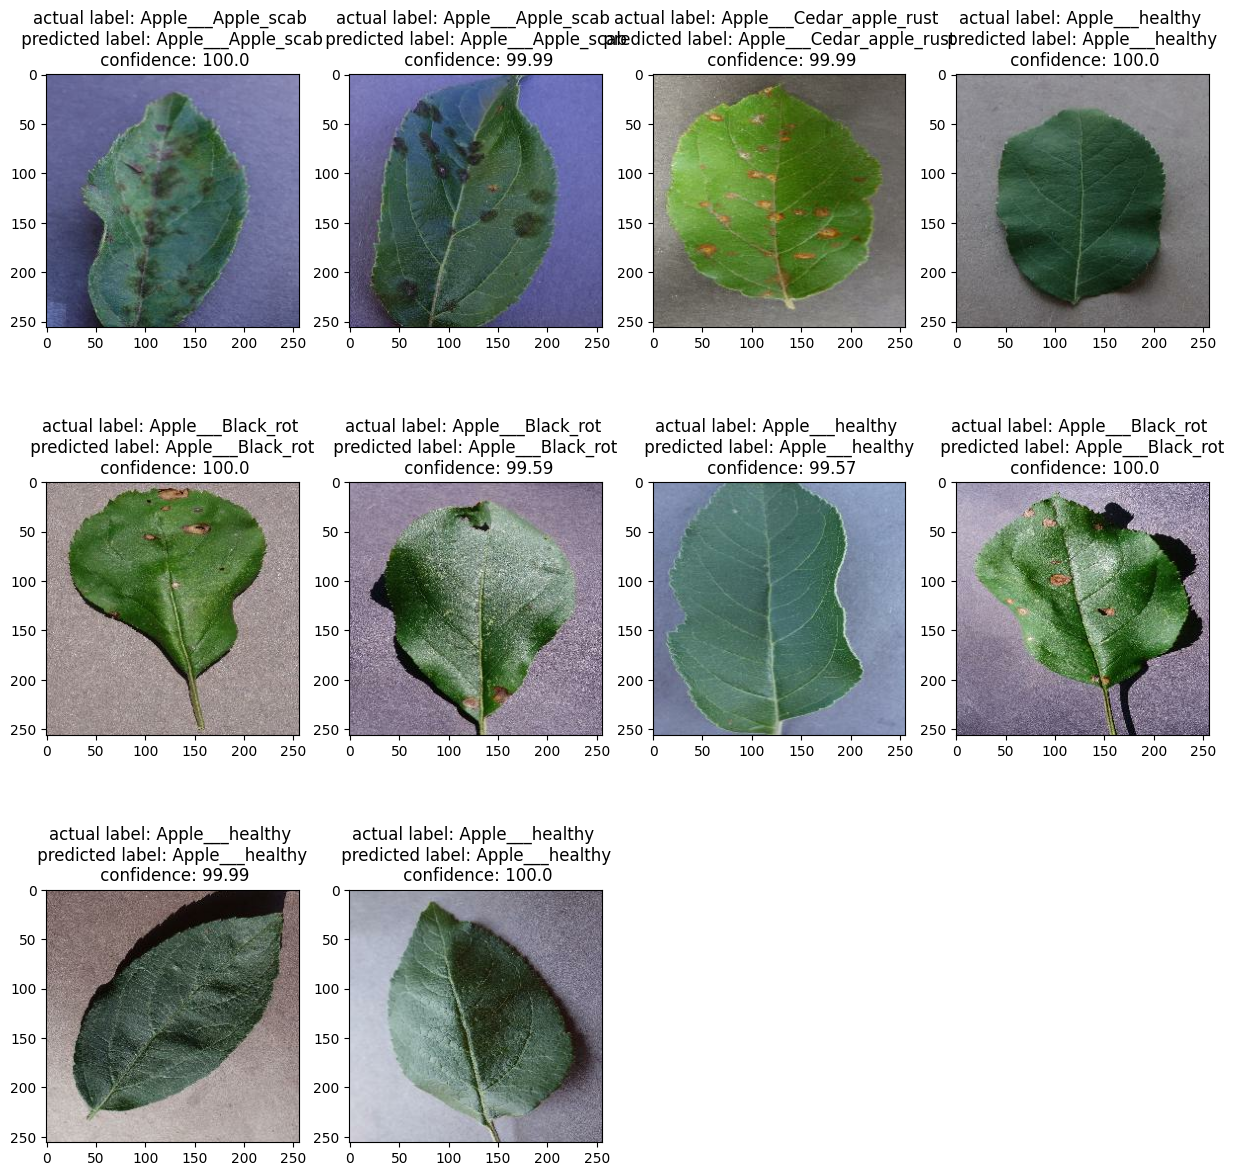

In [21]:
plt.figure(figsize=(15,15))
for img_batch,label_batch in test_data.take(1):
    for i in range(10):
        plt.subplot(3,4,i+1)
        p_class,p_conf = prediction(model,img_batch[i])
        plt.imshow(img_batch[i].numpy().astype('uint8'))
        plt.title(f'actual label: {classes[label_batch[i]]} \n predicted label: {p_class} \n confidence: {p_conf}' )

In [22]:
model.save("../models/apples")